In [145]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [146]:
root_path = 'gdrive/My Drive/Colab Notebooks/ML/Task 2/'
path_to_data_train = "dstc8-train.txt"
path_to_data_val = "dstc8-val-candidates.txt"
path_to_data_test = "dstc8-test-candidates.txt"

In [147]:
# Code extended from the following source: https://www.tensorflow.org/tutorials/text/nmt_with_attention
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.test.is_gpu_available()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import concurrent.futures
import collections
import unicodedata
import re
import numpy as np
import os
import io
import sys
import math
import time

In [148]:
#########################################
# RNN ENCODER-DECODER 
#########################################
#https://stackoverflow.com/questions/55490830/how-to-set-an-initial-state-for-a-bidirectional-lstm-layer-in-keras
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # tell LSTM you want to get the states, and sequences returned
        self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=0.1,
                                                                        go_backwards= True))


    def call(self, x, hidden):
        x = self.embedding(x)
        # no need to pass [hidden, hidden], just pass it as is
        output, forward_h, forward_c, backward_h, backward_c = self.lstmb(x, initial_state=hidden)
        return output, forward_h, forward_c, backward_h, backward_c


    def initialize_hidden_state(self):
      #4 for forward_h, forward_c, backward_h, backward_c
        return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstmb = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.dec_units,    
                                                                    return_sequences=True,
                                                                    return_state=True,
                                                                    dropout=0.1,
                                                                    go_backwards= True))

    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, initial_state):
    x = self.embedding(x)
    #Attention
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    #Take outputs from lstm
    x, h, c, b, b_c = self.lstmb(x, initial_state = initial_state)
    #Set states to both forward and backward pass
    states = tf.concat([h, b], axis=1)
    #Reshape output
    output = tf.reshape(x, (-1, x.shape[2]))
    #Set output
    x = self.fc(output)
    return x, states, attention_weights
    

In [149]:
#########################################
# TEXT PROCESSING
#########################################

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,Ã‚Â¿])", r" \1 ", w)
  w = re.sub(r'[" "]', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,Ã‚Â¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #print(lines)

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines]
  #print(word_pairs)
  return zip(*word_pairs)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path):
  inp_lang, targ_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

input_tensor_train, target_tensor_train, inp_lang, targ_lang = load_dataset(root_path + path_to_data_train)
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]
#print(len(input_tensor_train), len(target_tensor_train))

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

#print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
#print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

1 ----> <start>
4 ----> domain=music
16 ----> <sod>
29 ----> can
11 ----> you
36 ----> find
33 ----> song
65 ----> s
72 ----> from
53 ----> $artist
65 ----> s
463 ----> ablum
64 ----> $album
8 ----> ?
2 ----> <end>

1 ----> <start>
12 ----> i
65 ----> found
34 ----> $count
13 ----> song
25 ----> from
16 ----> $artist
67 ----> s
17 ----> $album
22 ----> album
3 ----> .
4 ----> the
13 ----> song
10 ----> is
8 ----> $song
6 ----> name
3 ----> .
2 ----> <end>


In [150]:
#########################################
# TRAINING
#########################################

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    #Get outputs from encoder
    enc_output, enc_hidden, forward_c, backward_h, backward_c = encoder(inp, enc_hidden) 
    #Inital state from outputs
    encoder_state = [enc_hidden, forward_c, backward_h, backward_c]
    #Hidden layer for decoder
    dec_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]): 
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, initial_state= encoder_state)
      loss += loss_function(targ[:, t], predictions)
      

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

def train_model(EPOCHS):
    loss_plot = []
    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden) #Breaks here
            total_loss += batch_loss

            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

        if (epoch + 1) == 100:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                            total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
        #Plot loss
        loss_plot.append(total_loss/steps_per_epoch)
        plt.plot(loss_plot, 'r')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

In [151]:
#########################################
# EVALUATION
#########################################

def evaluate(sentence, candidate=None, id=None):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = []
    for word in sentence.split(' '):
        if word in inp_lang.word_index:
            inputs.append(inp_lang.word_index[word])

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''
    value = 0
    #Set hidden to correct shape
    hidden = [tf.zeros((1, units)) for i in range(4)]
    #Get outputs from encoder
    enc_out, forward_h, forward_c, backward_h, backward_c = encoder(inputs, hidden)
    #Create inital state
    encoder_state = [forward_h, forward_c, backward_h, backward_c]
    #Create hidden for decoder
    dec_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    candidate_words = []
    if candidate != None:
        candidate = candidate + " <end>"
        for word in candidate.split(' '):
            if word in targ_lang.word_index:
                candidate_words.append(targ_lang.word_index[word])

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out, initial_state = encoder_state)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        if candidate == None:
            predicted_id = tf.argmax(predictions[0]).numpy()
        else:
            predicted_id = candidate_words[t]

        value += predictions[0][predicted_id].numpy()

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, value/t, id, sentence, attention_plot

        result += targ_lang.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, value/t, id, sentence, attention_plot

def loadTestData(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    lines = text.strip().split('\n')

    allCandidates = []
    candidates = []
    contexts = []

    for i in range(0, len(lines)):
        if lines[i].startswith("CONTEXT:"): 
            candidate = lines[i][8:]
            contexts.append(candidate)
            continue
            
        elif len(lines[i].strip()) == 0:
            if i>0: allCandidates.append(candidates)
            candidates = []
            
        else:
            candidate = lines[i][12:]
            candidates.append(candidate)
    
    allCandidates.append(candidates)
    return allCandidates, contexts

def getRankValue(target_value, unsorted_distribution):
    sorted_distribution = sorted(unsorted_distribution, reverse=True)
    #print("sorted_distribution="+str(sorted_distribution))
    for i in range (0, len(sorted_distribution)):
        value = sorted_distribution[i]
        #print("value(rank"+str((i+1))+")="+str(value)+" <==> target="+str(target_value))
        if value == target_value: 
            return 1/(i+1)
    return None
    
def evaluate_model(filename_testdata, checkpoint_dir, eval):
  #save to different files for eval and test comparison
    if eval == True:
      f_predicted = open(checkpoint_dir+"/dstc8-sgd-predicted.txt", 'w')
      f_reference = open(checkpoint_dir+"/dstc8-sgd-reference.txt", 'w')
    else:
      f_predicted = open(checkpoint_dir+"/dstc8-sgd-predicted_test.txt", 'w')
      f_reference = open(checkpoint_dir+"/dstc8-sgd-reference_test.txt", 'w')
    
    candidates, contexts = loadTestData(filename_testdata)
    correct_predictions = 0
    total_predictions = 0
    cumulative_mrr = 0
    recall_at_1 = None
    mrr = None

    for i in range(0, len(contexts)):
        total_predictions += 1
        #best_value = 0
        #best_index = 0
        response = ""
        response_value = 0
        response_attention_plot = []
        target_value = 0
        context = contexts[i]
        reference = candidates[i][0]
        distribution = []
        jobs = []

        with concurrent.futures.ThreadPoolExecutor() as executor:
            jobs.append(executor.submit(evaluate, preprocess_sentence(context), None, 0))
            for j in range (0,len(candidates[i])):
                jobs.append(executor.submit(evaluate, preprocess_sentence(context), candidates[i][j], (j+1)))
        
        for future in concurrent.futures.as_completed(jobs):
            candidate_sentence, value_candidate, id, inp_sentence, attention_plot = future.result()
            if id == 0:
                response = candidate_sentence
                response_value = value_candidate
                response_attention_plot = attention_plot
                #print(str(i+1)+' '+str(id)+' predicted_sentence:', candidate_sentence, 'value:', value_candidate) 
            else:
                distribution.append(value_candidate)
                #print(str(i+1)+' '+str(id)+' candidate_sentence:', candidate_sentence, 'value:', value_candidate) 

            if id == 1: target_value = value_candidate

            #if value_candidate > best_value:
            #    best_value = value_candidate
            #    best_index = id

        rank = getRankValue(target_value, distribution)
        cumulative_mrr += rank
        correct_predictions += 1 if rank == 1 else 0
        
        recall_at_1 = correct_predictions/total_predictions
        mrr = cumulative_mrr/total_predictions
        #print(str(i)+' INPUT='+str(context)+' PREDICTED='+str(response)+' REFERENCE='+str(reference)+' CumulativeR@1='+str(recall_at_1)+' ('+str(correct_predictions)+' out of '+str(total_predictions)+') CumulativeMRR='+str(mrr)+' ('+str(cumulative_mrr)+' out of '+str(total_predictions)+')')
        #print("")
        #plot_attention(response_attention_plot, context.split(' '), response.split(' '))

        f_predicted.write(response+"\n")
        f_reference.write(reference+"\n")
    
    f_predicted.close()
    f_reference.close()

    print("BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under "+str(checkpoint_dir))
    print("RECALL@1="+str(recall_at_1))
    print("Mean Reciprocal Rank="+str(mrr))
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

Training
Epoch 1 Batch 0 Loss 1.8960
Epoch 1 Loss 1.3746
Time taken for 1 epoch 108.59789395332336 sec



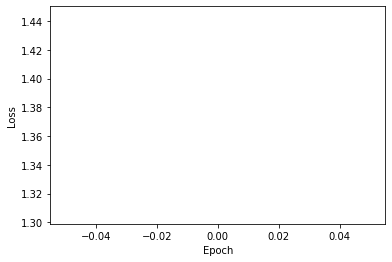

Epoch 2 Batch 0 Loss 1.0451
Epoch 2 Loss 0.8110
Time taken for 1 epoch 21.672471523284912 sec



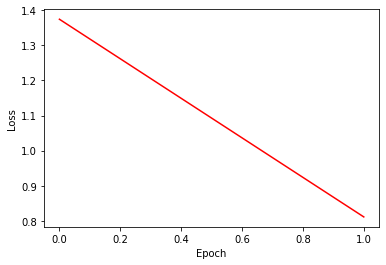

Epoch 3 Batch 0 Loss 0.7310
Epoch 3 Loss 0.6059
Time taken for 1 epoch 21.53303027153015 sec



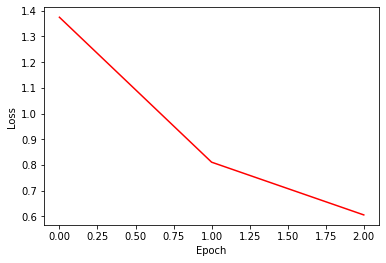

Epoch 4 Batch 0 Loss 0.5293
Epoch 4 Loss 0.5138
Time taken for 1 epoch 21.707316637039185 sec



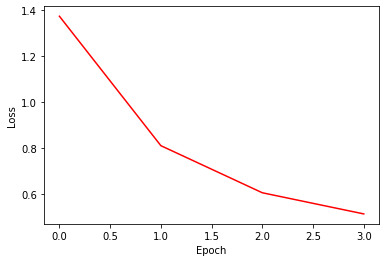

Epoch 5 Batch 0 Loss 0.5849
Epoch 5 Loss 0.4658
Time taken for 1 epoch 21.682241201400757 sec



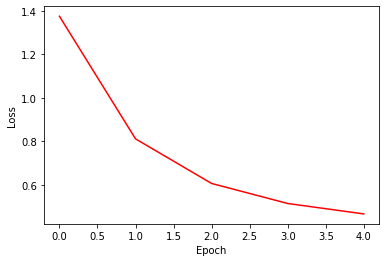

Epoch 6 Batch 0 Loss 0.4052
Epoch 6 Loss 0.4349
Time taken for 1 epoch 21.687662363052368 sec



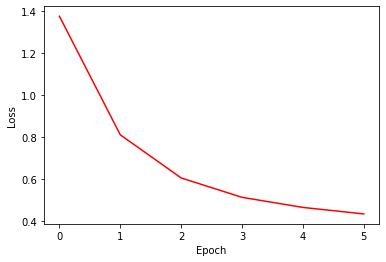

Epoch 7 Batch 0 Loss 0.4319
Epoch 7 Loss 0.4110
Time taken for 1 epoch 21.683815956115723 sec



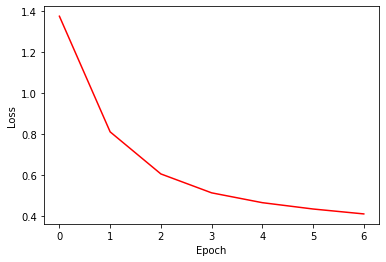

Epoch 8 Batch 0 Loss 0.4195
Epoch 8 Loss 0.3906
Time taken for 1 epoch 21.6726553440094 sec



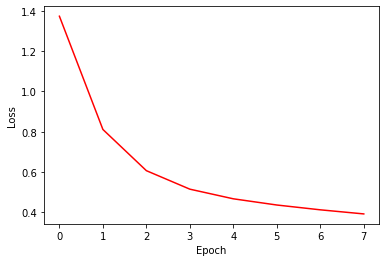

Epoch 9 Batch 0 Loss 0.3928
Epoch 9 Loss 0.3752
Time taken for 1 epoch 21.590511322021484 sec



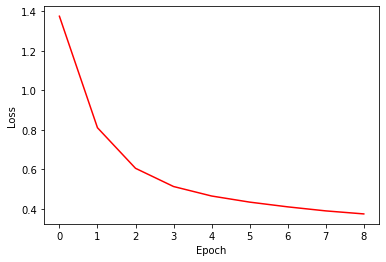

Epoch 10 Batch 0 Loss 0.3114
Epoch 10 Loss 0.3576
Time taken for 1 epoch 21.742501258850098 sec



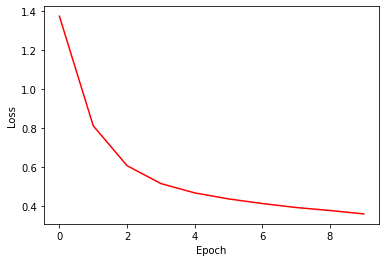

Epoch 11 Batch 0 Loss 0.2936
Epoch 11 Loss 0.3418
Time taken for 1 epoch 21.734150171279907 sec



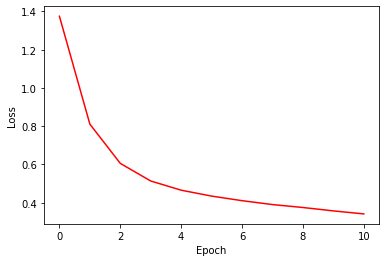

Epoch 12 Batch 0 Loss 0.2988
Epoch 12 Loss 0.3263
Time taken for 1 epoch 21.723928689956665 sec



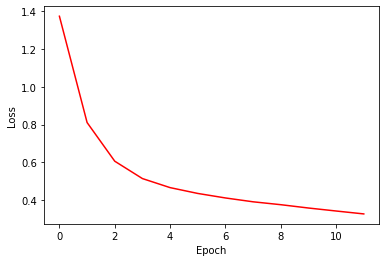

Epoch 13 Batch 0 Loss 0.2725
Epoch 13 Loss 0.3092
Time taken for 1 epoch 21.720465421676636 sec



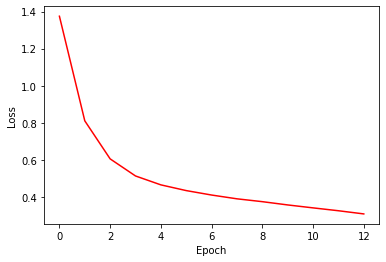

Epoch 14 Batch 0 Loss 0.2676
Epoch 14 Loss 0.2932
Time taken for 1 epoch 21.72102451324463 sec



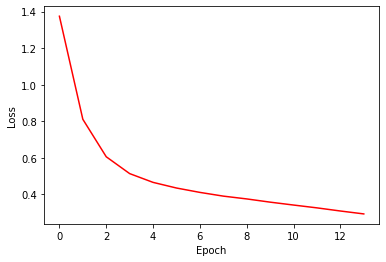

Epoch 15 Batch 0 Loss 0.2702
Epoch 15 Loss 0.2769
Time taken for 1 epoch 21.58540940284729 sec



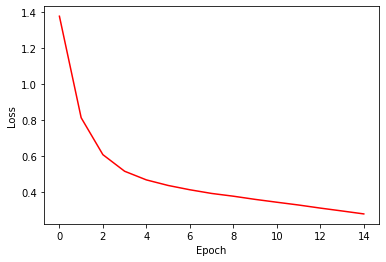

Epoch 16 Batch 0 Loss 0.2399
Epoch 16 Loss 0.2573
Time taken for 1 epoch 21.732295274734497 sec



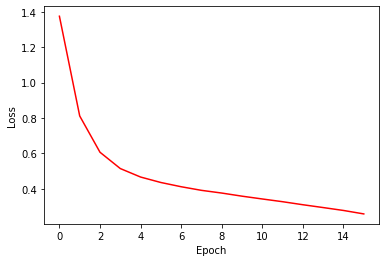

Epoch 17 Batch 0 Loss 0.2546
Epoch 17 Loss 0.2400
Time taken for 1 epoch 21.75469136238098 sec



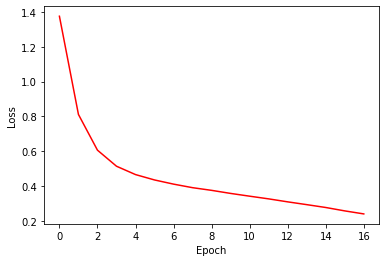

Epoch 18 Batch 0 Loss 0.2091
Epoch 18 Loss 0.2170
Time taken for 1 epoch 21.727317094802856 sec



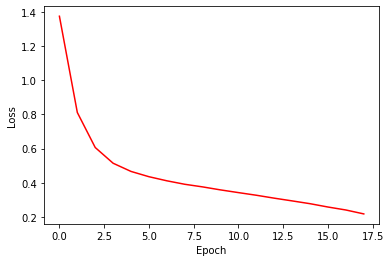

Epoch 19 Batch 0 Loss 0.1806
Epoch 19 Loss 0.1958
Time taken for 1 epoch 21.73231792449951 sec



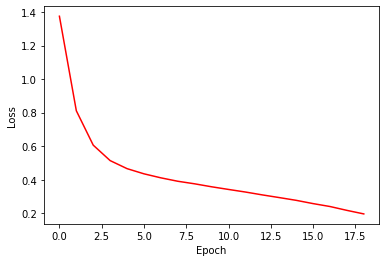

Epoch 20 Batch 0 Loss 0.1637
Epoch 20 Loss 0.1779
Time taken for 1 epoch 21.703904151916504 sec



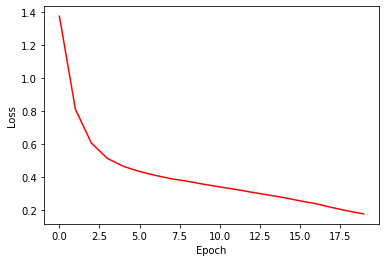

Epoch 21 Batch 0 Loss 0.1819
Epoch 21 Loss 0.1574
Time taken for 1 epoch 21.581984043121338 sec



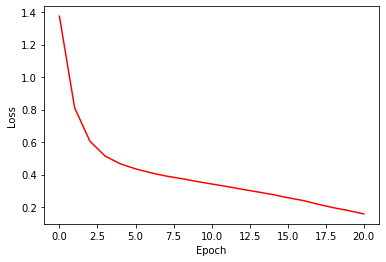

Epoch 22 Batch 0 Loss 0.1170
Epoch 22 Loss 0.1376
Time taken for 1 epoch 21.754115104675293 sec



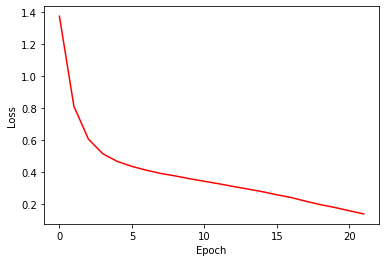

Epoch 23 Batch 0 Loss 0.1318
Epoch 23 Loss 0.1216
Time taken for 1 epoch 21.72896695137024 sec



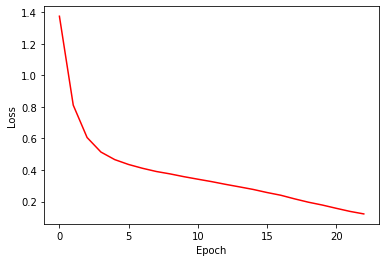

Epoch 24 Batch 0 Loss 0.1019
Epoch 24 Loss 0.1038
Time taken for 1 epoch 21.746087551116943 sec



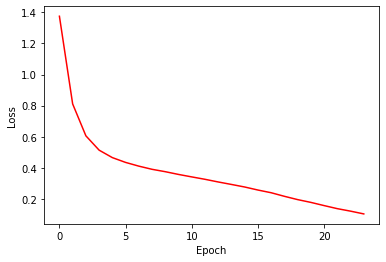

Epoch 25 Batch 0 Loss 0.0763
Epoch 25 Loss 0.0900
Time taken for 1 epoch 21.727051973342896 sec



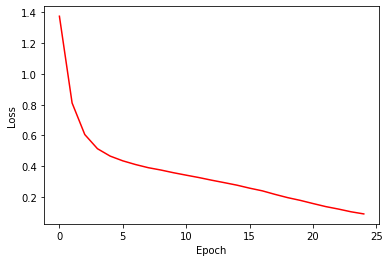

Epoch 26 Batch 0 Loss 0.0803
Epoch 26 Loss 0.0793
Time taken for 1 epoch 21.6587553024292 sec



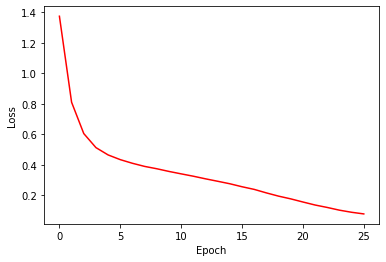

Epoch 27 Batch 0 Loss 0.0638
Epoch 27 Loss 0.0718
Time taken for 1 epoch 21.71021318435669 sec



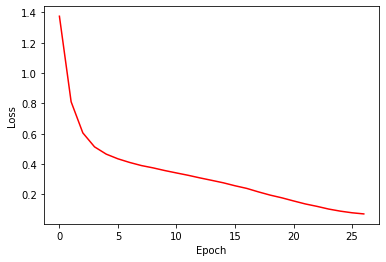

Epoch 28 Batch 0 Loss 0.0525
Epoch 28 Loss 0.0647
Time taken for 1 epoch 21.736052989959717 sec



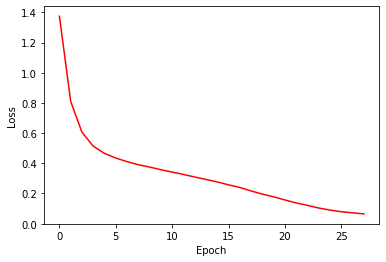

Epoch 29 Batch 0 Loss 0.0684
Epoch 29 Loss 0.0601
Time taken for 1 epoch 21.698803663253784 sec



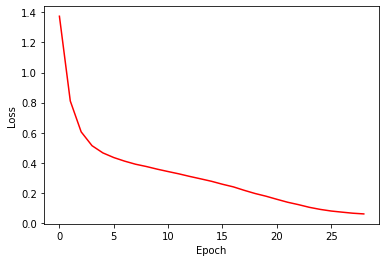

Epoch 30 Batch 0 Loss 0.0423
Epoch 30 Loss 0.0520
Time taken for 1 epoch 21.71406102180481 sec



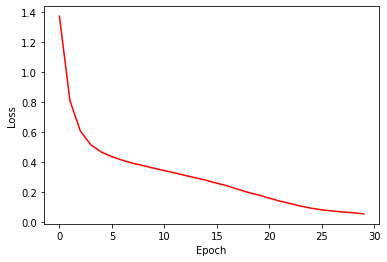

Epoch 31 Batch 0 Loss 0.0369
Epoch 31 Loss 0.0509
Time taken for 1 epoch 21.721344470977783 sec



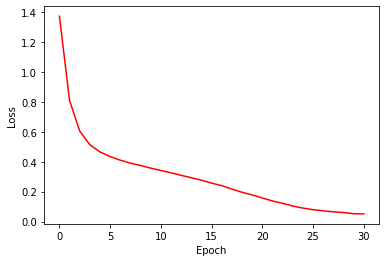

Epoch 32 Batch 0 Loss 0.0529
Epoch 32 Loss 0.0448
Time taken for 1 epoch 21.56144142150879 sec



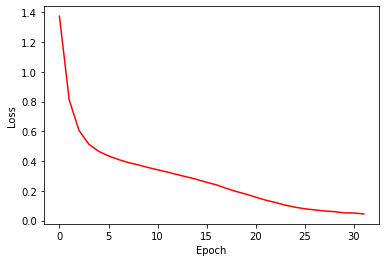

Epoch 33 Batch 0 Loss 0.0249
Epoch 33 Loss 0.0401
Time taken for 1 epoch 21.73119020462036 sec



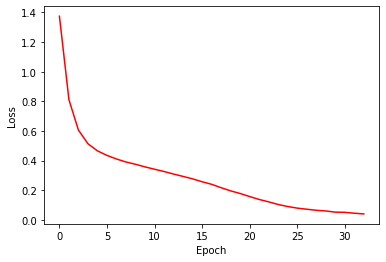

Epoch 34 Batch 0 Loss 0.0246
Epoch 34 Loss 0.0370
Time taken for 1 epoch 21.714109182357788 sec



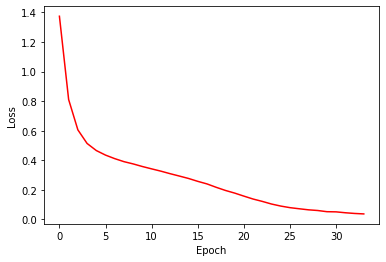

Epoch 35 Batch 0 Loss 0.0334
Epoch 35 Loss 0.0373
Time taken for 1 epoch 21.691797971725464 sec



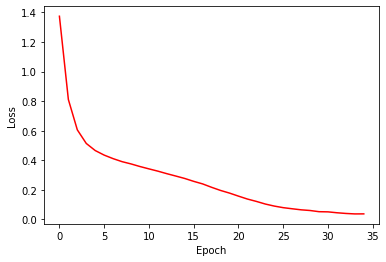

Epoch 36 Batch 0 Loss 0.0399
Epoch 36 Loss 0.0432
Time taken for 1 epoch 21.717588901519775 sec



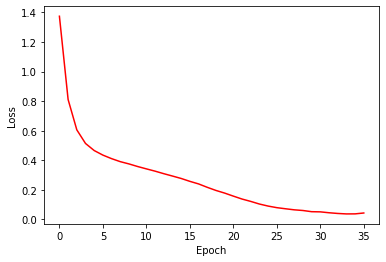

Epoch 37 Batch 0 Loss 0.0294
Epoch 37 Loss 0.0366
Time taken for 1 epoch 21.726096153259277 sec



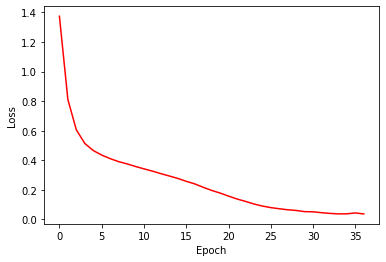

Epoch 38 Batch 0 Loss 0.0337
Epoch 38 Loss 0.0343
Time taken for 1 epoch 21.560028791427612 sec



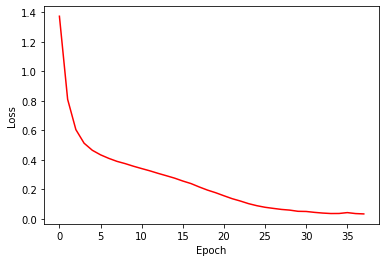

Epoch 39 Batch 0 Loss 0.0262
Epoch 39 Loss 0.0315
Time taken for 1 epoch 21.72184133529663 sec



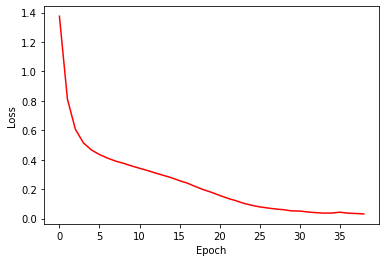

Epoch 40 Batch 0 Loss 0.0293
Epoch 40 Loss 0.0297
Time taken for 1 epoch 21.71404767036438 sec



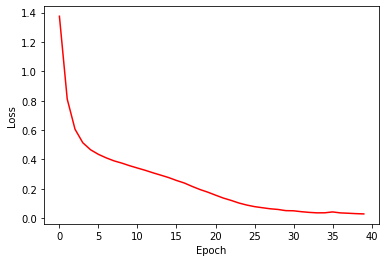

Epoch 41 Batch 0 Loss 0.0269
Epoch 41 Loss 0.0295
Time taken for 1 epoch 21.696760654449463 sec



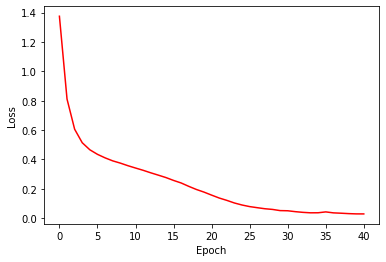

Epoch 42 Batch 0 Loss 0.0338
Epoch 42 Loss 0.0285
Time taken for 1 epoch 21.72554588317871 sec



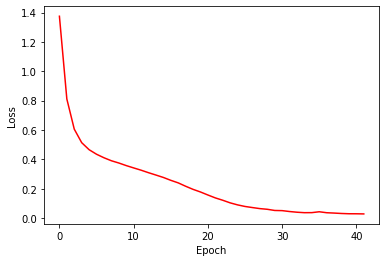

Epoch 43 Batch 0 Loss 0.0324
Epoch 43 Loss 0.0287
Time taken for 1 epoch 21.74991774559021 sec



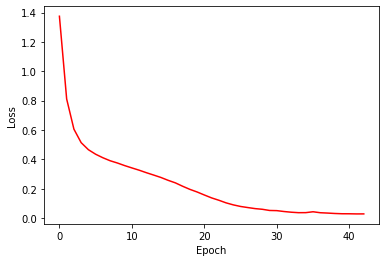

Epoch 44 Batch 0 Loss 0.0181
Epoch 44 Loss 0.0296
Time taken for 1 epoch 21.568288326263428 sec



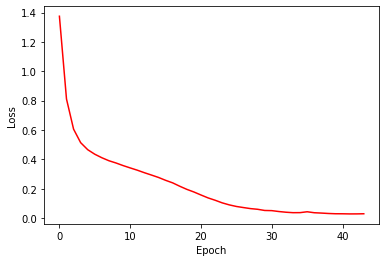

Epoch 45 Batch 0 Loss 0.0277
Epoch 45 Loss 0.0312
Time taken for 1 epoch 21.717803716659546 sec



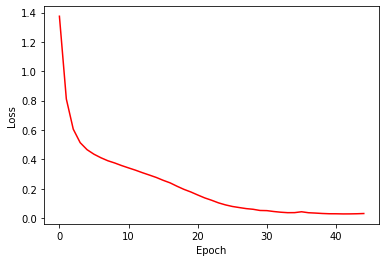

Epoch 46 Batch 0 Loss 0.0254
Epoch 46 Loss 0.0295
Time taken for 1 epoch 21.71036410331726 sec



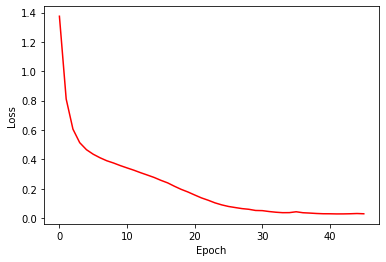

Epoch 47 Batch 0 Loss 0.0246
Epoch 47 Loss 0.0292
Time taken for 1 epoch 21.73035979270935 sec



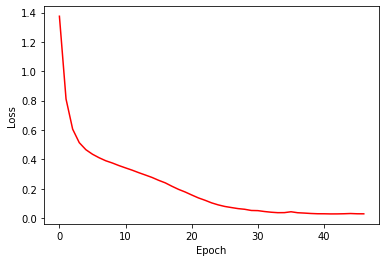

Epoch 48 Batch 0 Loss 0.0197
Epoch 48 Loss 0.0282
Time taken for 1 epoch 21.72829270362854 sec



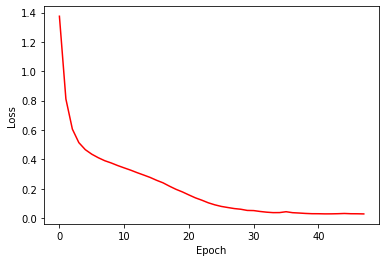

Epoch 49 Batch 0 Loss 0.0180
Epoch 49 Loss 0.0274
Time taken for 1 epoch 21.697850942611694 sec



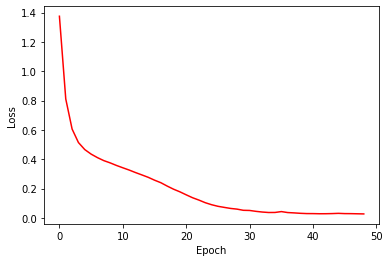

Epoch 50 Batch 0 Loss 0.0213
Epoch 50 Loss 0.0292
Time taken for 1 epoch 21.544516563415527 sec



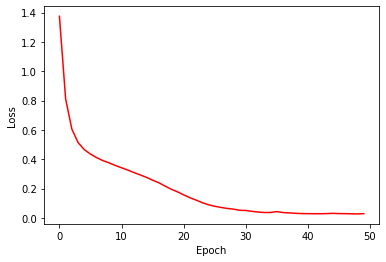

Epoch 51 Batch 0 Loss 0.0303
Epoch 51 Loss 0.0301
Time taken for 1 epoch 21.691375494003296 sec



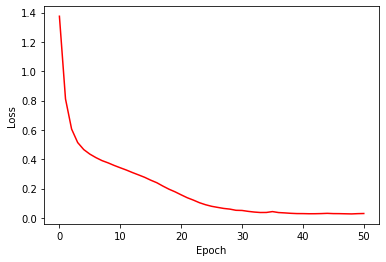

Epoch 52 Batch 0 Loss 0.0191
Epoch 52 Loss 0.0293
Time taken for 1 epoch 21.725054264068604 sec



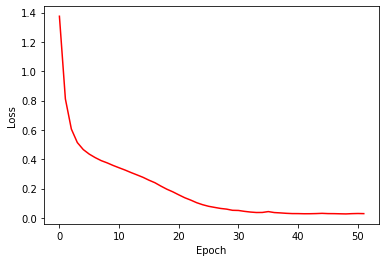

Epoch 53 Batch 0 Loss 0.0224
Epoch 53 Loss 0.0271
Time taken for 1 epoch 21.72085738182068 sec



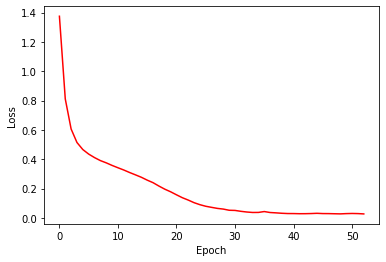

Epoch 54 Batch 0 Loss 0.0233
Epoch 54 Loss 0.0278
Time taken for 1 epoch 21.721805572509766 sec



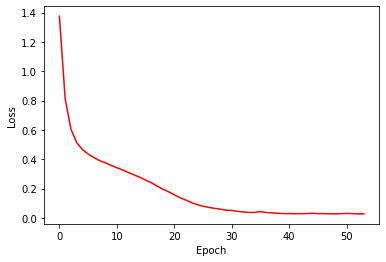

Epoch 55 Batch 0 Loss 0.0253
Epoch 55 Loss 0.0271
Time taken for 1 epoch 21.71169424057007 sec



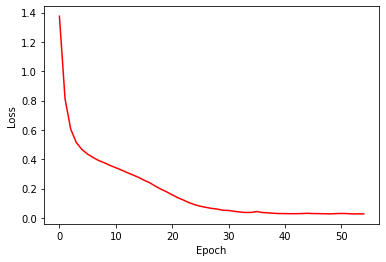

Epoch 56 Batch 0 Loss 0.0139
Epoch 56 Loss 0.0250
Time taken for 1 epoch 21.575784921646118 sec



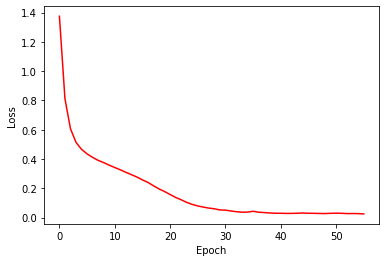

Epoch 57 Batch 0 Loss 0.0194
Epoch 57 Loss 0.0240
Time taken for 1 epoch 21.717050552368164 sec



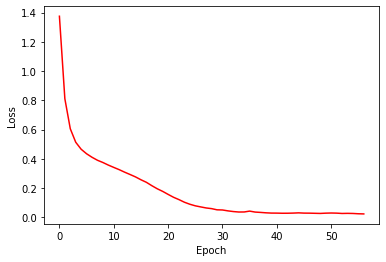

Epoch 58 Batch 0 Loss 0.0120
Epoch 58 Loss 0.0234
Time taken for 1 epoch 21.715071201324463 sec



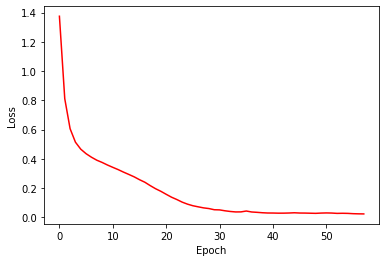

Epoch 59 Batch 0 Loss 0.0168
Epoch 59 Loss 0.0231
Time taken for 1 epoch 21.707313537597656 sec



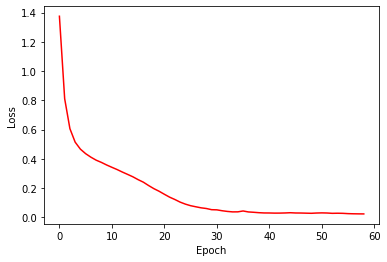

Epoch 60 Batch 0 Loss 0.0200
Epoch 60 Loss 0.0236
Time taken for 1 epoch 21.714488983154297 sec



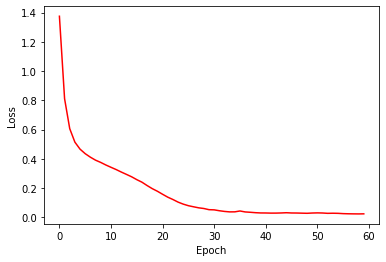

Epoch 61 Batch 0 Loss 0.0242
Epoch 61 Loss 0.0239
Time taken for 1 epoch 21.728883743286133 sec



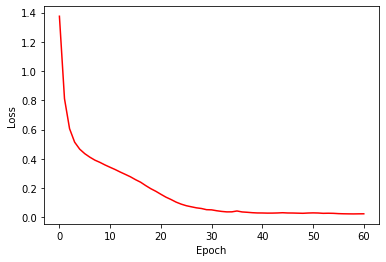

Epoch 62 Batch 0 Loss 0.0226
Epoch 62 Loss 0.0246
Time taken for 1 epoch 21.56840944290161 sec



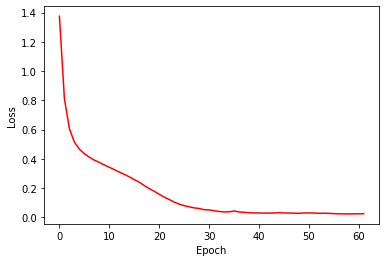

Epoch 63 Batch 0 Loss 0.0201
Epoch 63 Loss 0.0273
Time taken for 1 epoch 21.710686922073364 sec



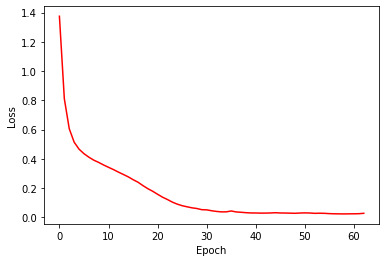

Epoch 64 Batch 0 Loss 0.0231
Epoch 64 Loss 0.0271
Time taken for 1 epoch 21.715062618255615 sec



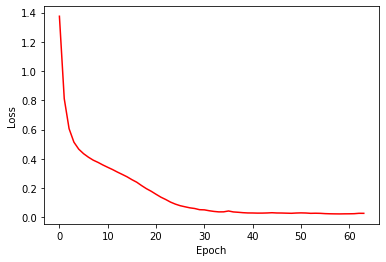

Epoch 65 Batch 0 Loss 0.0169
Epoch 65 Loss 0.0295
Time taken for 1 epoch 21.73155117034912 sec



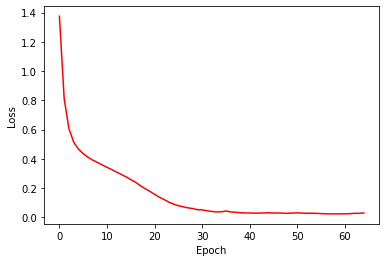

Epoch 66 Batch 0 Loss 0.0260
Epoch 66 Loss 0.0333
Time taken for 1 epoch 21.720970153808594 sec



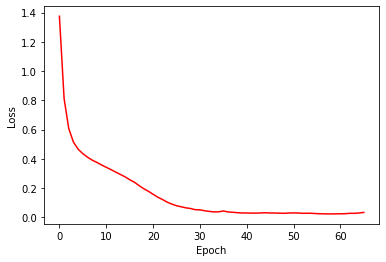

Epoch 67 Batch 0 Loss 0.0226
Epoch 67 Loss 0.0330
Time taken for 1 epoch 21.66719651222229 sec



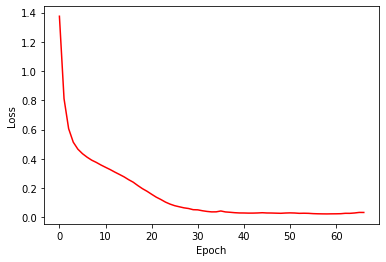

Epoch 68 Batch 0 Loss 0.0348
Epoch 68 Loss 0.0313
Time taken for 1 epoch 21.628276348114014 sec



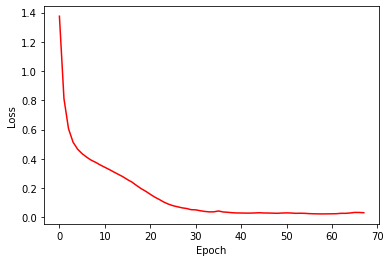

Epoch 69 Batch 0 Loss 0.0339
Epoch 69 Loss 0.0303
Time taken for 1 epoch 21.71865177154541 sec



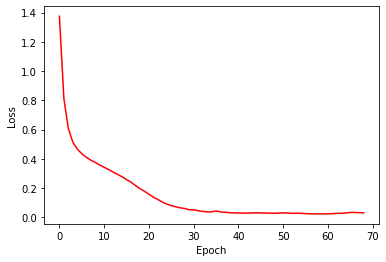

Epoch 70 Batch 0 Loss 0.0272
Epoch 70 Loss 0.0308
Time taken for 1 epoch 21.701547861099243 sec



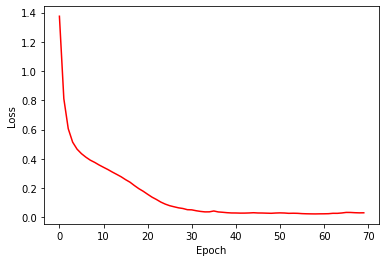

Epoch 71 Batch 0 Loss 0.0272
Epoch 71 Loss 0.0303
Time taken for 1 epoch 21.70115327835083 sec



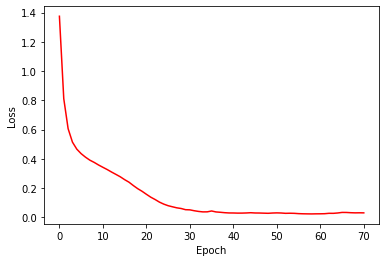

Epoch 72 Batch 0 Loss 0.0184
Epoch 72 Loss 0.0290
Time taken for 1 epoch 21.69498300552368 sec



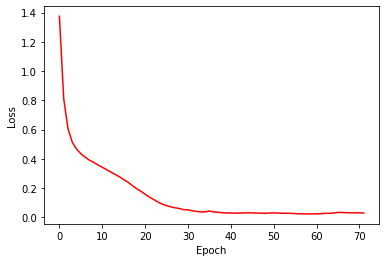

Epoch 73 Batch 0 Loss 0.0228
Epoch 73 Loss 0.0273
Time taken for 1 epoch 21.60530686378479 sec



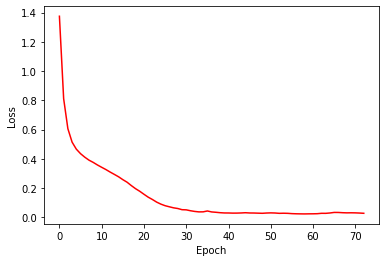

Epoch 74 Batch 0 Loss 0.0179
Epoch 74 Loss 0.0251
Time taken for 1 epoch 21.671391248703003 sec



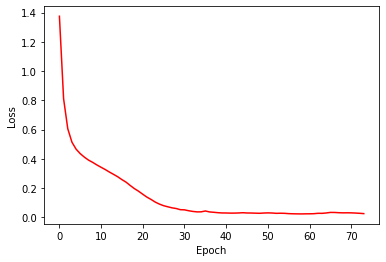

Epoch 75 Batch 0 Loss 0.0206
Epoch 75 Loss 0.0236
Time taken for 1 epoch 21.70180654525757 sec



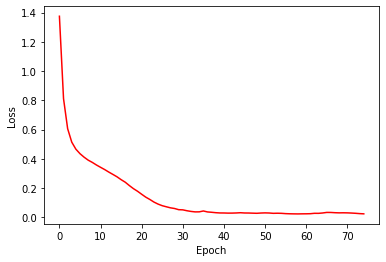

Epoch 76 Batch 0 Loss 0.0230
Epoch 76 Loss 0.0232
Time taken for 1 epoch 21.68793535232544 sec



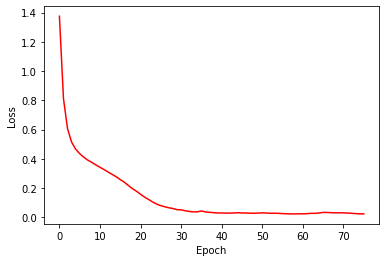

Epoch 77 Batch 0 Loss 0.0254
Epoch 77 Loss 0.0237
Time taken for 1 epoch 21.71947193145752 sec



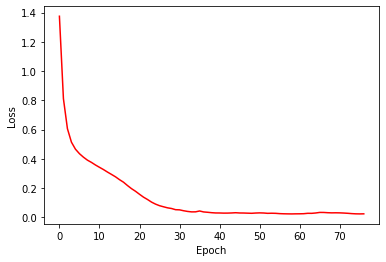

Epoch 78 Batch 0 Loss 0.0259
Epoch 78 Loss 0.0238
Time taken for 1 epoch 21.71657133102417 sec



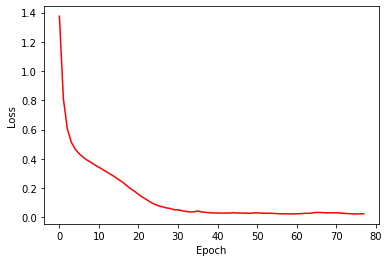

Epoch 79 Batch 0 Loss 0.0189
Epoch 79 Loss 0.0228
Time taken for 1 epoch 21.57210350036621 sec



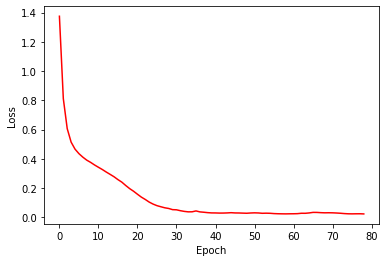

Epoch 80 Batch 0 Loss 0.0217
Epoch 80 Loss 0.0220
Time taken for 1 epoch 21.697988986968994 sec



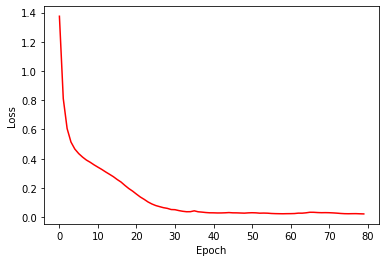

Epoch 81 Batch 0 Loss 0.0156
Epoch 81 Loss 0.0213
Time taken for 1 epoch 21.726113319396973 sec



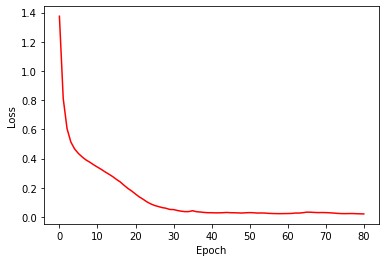

Epoch 82 Batch 0 Loss 0.0184
Epoch 82 Loss 0.0206
Time taken for 1 epoch 21.72293210029602 sec



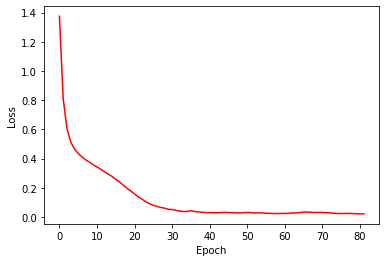

Epoch 83 Batch 0 Loss 0.0143
Epoch 83 Loss 0.0200
Time taken for 1 epoch 21.71596646308899 sec



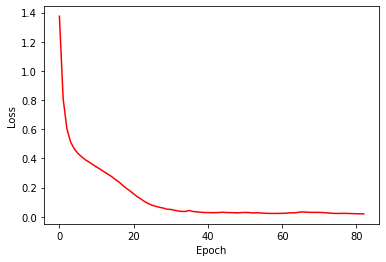

Epoch 84 Batch 0 Loss 0.0174
Epoch 84 Loss 0.0198
Time taken for 1 epoch 21.72626042366028 sec



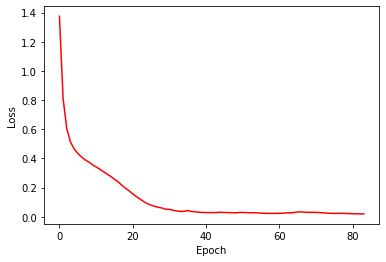

Epoch 85 Batch 0 Loss 0.0131
Epoch 85 Loss 0.0198
Time taken for 1 epoch 21.58822536468506 sec



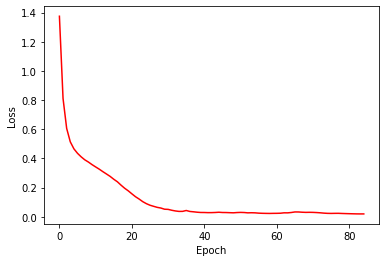

Epoch 86 Batch 0 Loss 0.0099
Epoch 86 Loss 0.0200
Time taken for 1 epoch 21.723206520080566 sec



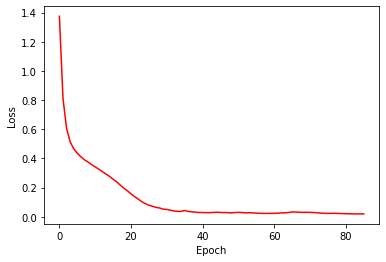

Epoch 87 Batch 0 Loss 0.0146
Epoch 87 Loss 0.0202
Time taken for 1 epoch 21.705448150634766 sec



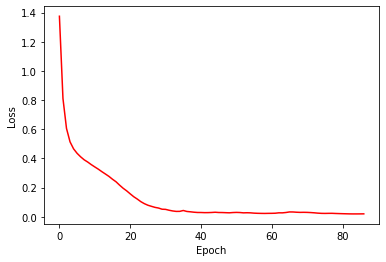

Epoch 88 Batch 0 Loss 0.0152
Epoch 88 Loss 0.0207
Time taken for 1 epoch 21.724162340164185 sec



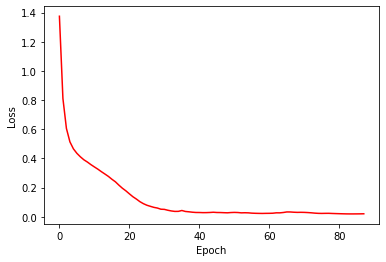

Epoch 89 Batch 0 Loss 0.0185
Epoch 89 Loss 0.0205
Time taken for 1 epoch 21.727205991744995 sec



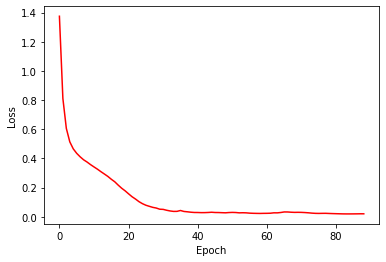

Epoch 90 Batch 0 Loss 0.0184
Epoch 90 Loss 0.0206
Time taken for 1 epoch 21.726500988006592 sec



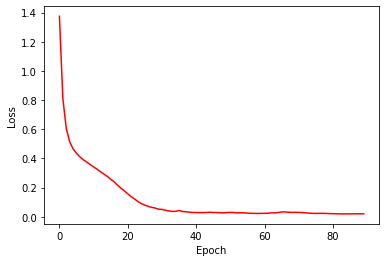

Epoch 91 Batch 0 Loss 0.0134
Epoch 91 Loss 0.0200
Time taken for 1 epoch 21.60309100151062 sec



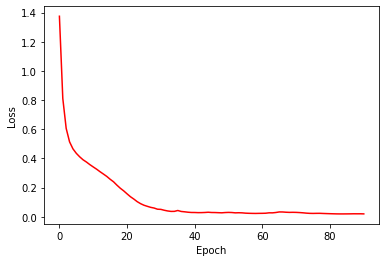

Epoch 92 Batch 0 Loss 0.0143
Epoch 92 Loss 0.0200
Time taken for 1 epoch 21.709049463272095 sec



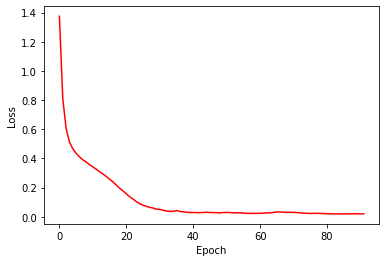

Epoch 93 Batch 0 Loss 0.0150
Epoch 93 Loss 0.0205
Time taken for 1 epoch 21.690140962600708 sec



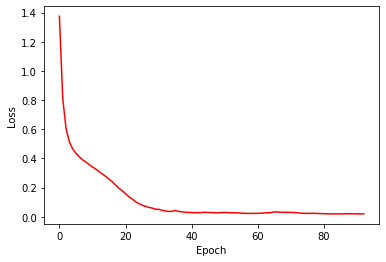

Epoch 94 Batch 0 Loss 0.0187
Epoch 94 Loss 0.0233
Time taken for 1 epoch 21.7157781124115 sec



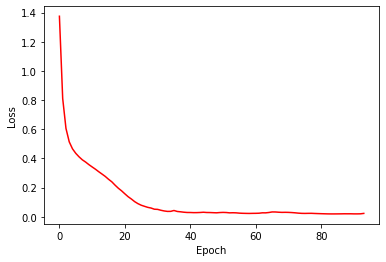

Epoch 95 Batch 0 Loss 0.0345
Epoch 95 Loss 0.0340
Time taken for 1 epoch 21.70523715019226 sec



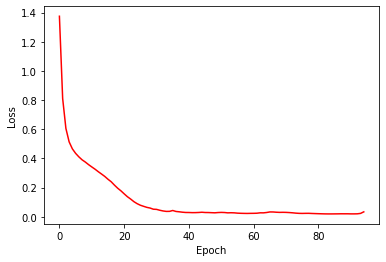

Epoch 96 Batch 0 Loss 0.0486
Epoch 96 Loss 0.0410
Time taken for 1 epoch 21.71454691886902 sec



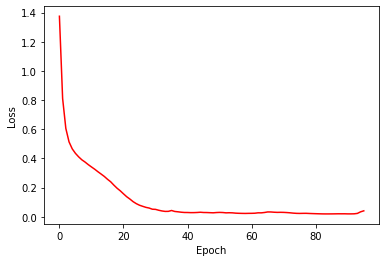

Epoch 97 Batch 0 Loss 0.0360
Epoch 97 Loss 0.0398
Time taken for 1 epoch 21.56699013710022 sec



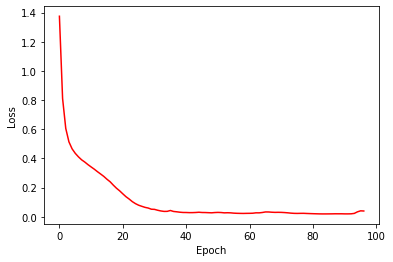

Epoch 98 Batch 0 Loss 0.0210
Epoch 98 Loss 0.0389
Time taken for 1 epoch 21.71324849128723 sec



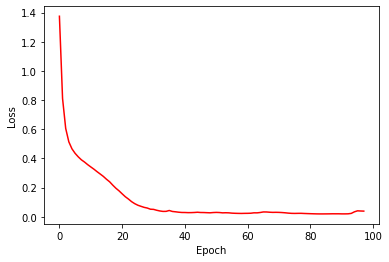

Epoch 99 Batch 0 Loss 0.0345
Epoch 99 Loss 0.0389
Time taken for 1 epoch 21.697900533676147 sec



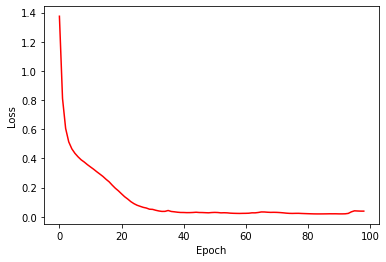

Epoch 100 Batch 0 Loss 0.0233
Epoch 100 Loss 0.0297
Time taken for 1 epoch 24.969071865081787 sec



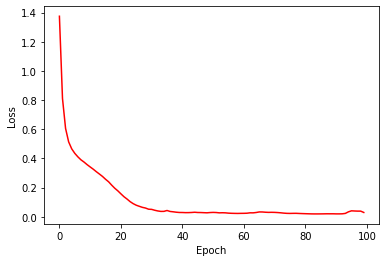

Validation
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.6338383838383839
Mean Reciprocal Rank=0.7707466530383191
Testing
BLUE Scores=go to https://www.letsmt.eu/Bleu.aspx and provide your *.txt files under gdrive/My Drive/Colab Notebooks/ML/Task 2//training_checkpoints
RECALL@1=0.47346938775510206
Mean Reciprocal Rank=0.6479794298671847
Execution time=6596.831203222275 secs.


In [152]:
#########################################
# MAIN PROGRAM
"""
Lines have been commented out above so that the notebook can be read on git. 
If the attention plots are needed just uncomment the appropriate lines.
All hyperparams have been kept the same though all models.
"""
# Params set from baseline
start_exec_time = time.time()
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
#Vocab setting
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1
#Read in data
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#batch the data
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#Create encoder with hidden state
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
#Bidirectional so need forward and back
sample_output, forward_h, forward_c, backward_h, backward_c = encoder(example_input_batch, sample_hidden)

#Concat the forward and backward pass as the sample hidden to decoder
sample_hidden = tf.keras.layers.Concatenate()([forward_h, backward_h])
#Create decoder
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
#Get output from decoder, pass in initial state of encoder
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output, initial_state = [forward_h, forward_c, backward_h, backward_c])

#Save checkpoints
checkpoint_dir = root_path + '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

#Same epochs for all
epoch = 100
for filename in os.listdir(checkpoint_dir):
  print("Erasing file " +str(filename))
  os.remove(checkpoint_dir + "/" + filename)
print("Training")
train_model(epoch)
print("Validation")
evaluate_model(root_path + path_to_data_val, checkpoint_dir, eval=True)
print("Testing")
evaluate_model(root_path + path_to_data_test, checkpoint_dir, eval=False)

exec_time = time.time() - start_exec_time
print("Execution time="+str(exec_time)+" secs.")